In [1]:
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Đọc dữ liệu
df = pd.read_csv('/content/USDT-USD.csv', parse_dates=['Date'], index_col='Date')

# Chọn cột giá cần dự đoán (giả sử là 'Close')
data = df['Close']


ADF Statistic: -6.056748082109847
p-value: 1.239918557062455e-07
Giá trị sau khi thu được khác biệt
ADF Statistic: -6.056748082109847
p-value: 1.239918557062455e-07


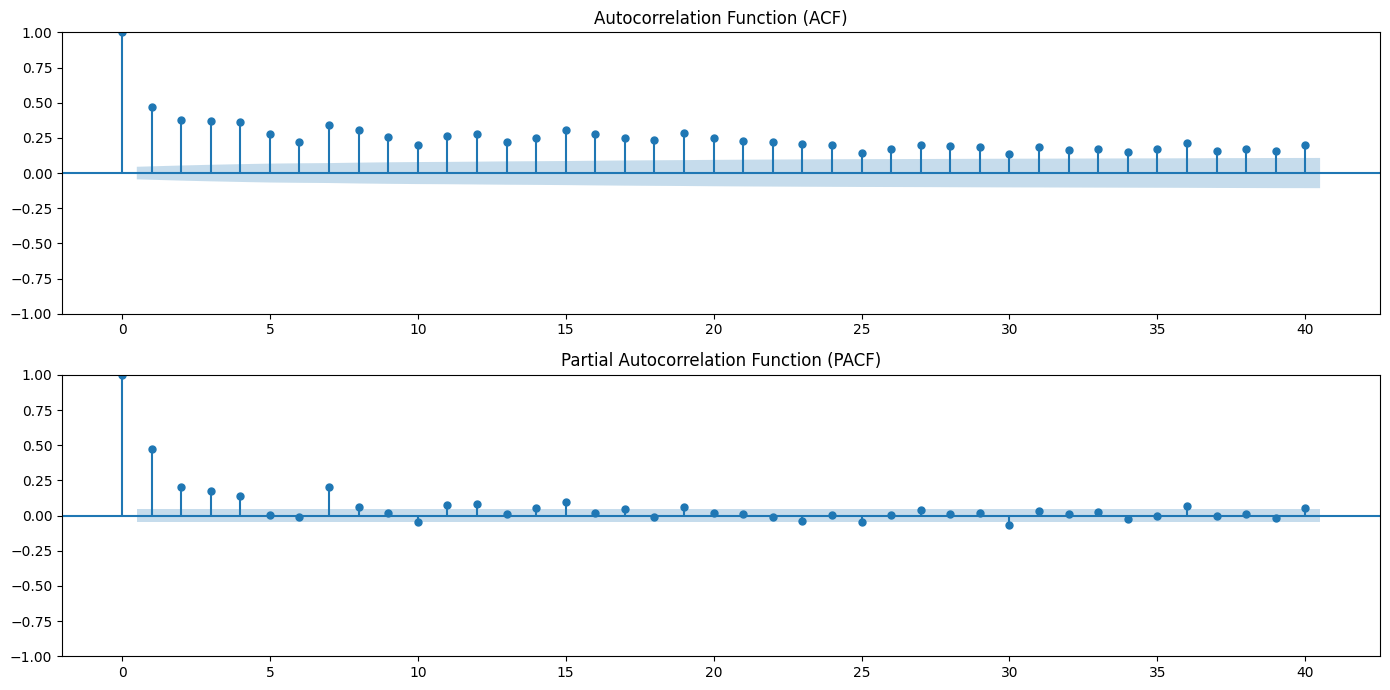

In [3]:
# Bước 1: Kiểm tra tính dừng của dữ liệu
adf_result = adfuller(data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Nếu chuỗi không dừng, thực hiện khác biệt hóa
if adf_result[1] > 0.05:
    data_diff = data.diff().dropna()
else:
    data_diff = data

adf_result = adfuller(data_diff)
print(f"Giá trị sau khi thu được khác biệt")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
# Vẽ đồ thị ACF và PACF
plt.figure(figsize=(14, 7))
plt.subplot(211)
plot_acf(data_diff, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(data_diff, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

**Chia tập dữ liệu 7:3**

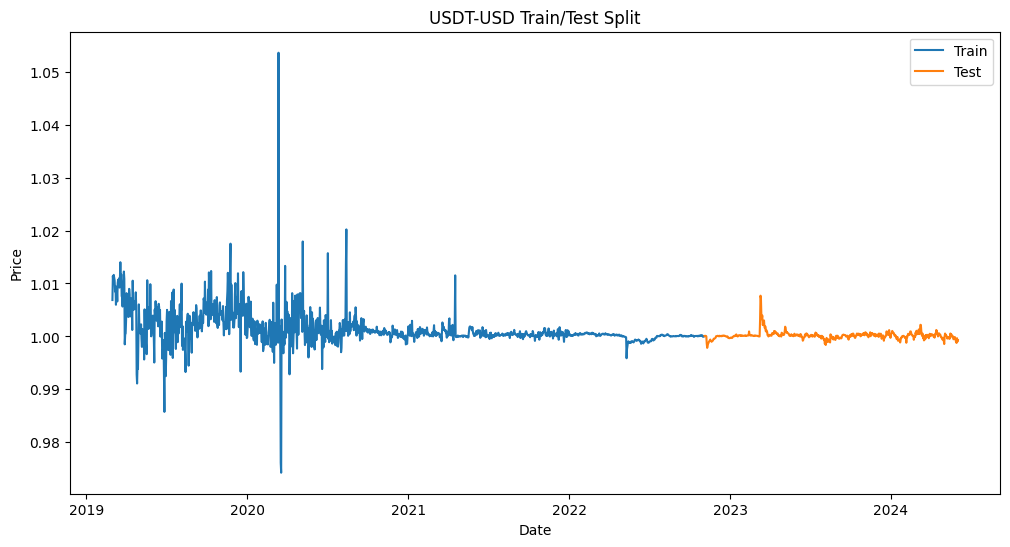

In [4]:
# Bước 2: Phân chia dữ liệu: 70% train, 30% test
train_size = int(len(data_diff) * 0.70)
train_data = data_diff.iloc[:train_size]
test_data = data_diff.iloc[train_size:]

# Vẽ biểu đồ để kiểm tra
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.title('USDT-USD Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [5]:
# Bước 3: Tìm kiếm mô hình SARIMA tốt nhất bằng Grid Search
p = d = q = range(0, 3)  # Định nghĩa phạm vi cho các tham số (p, d, q)
P = D = Q = range(0, 2)  # Định nghĩa phạm vi cho các tham số mùa vụ (P, D, Q)
s = [12]  # Kỳ mùa vụ (thường là 12 cho dữ liệu hàng tháng)

# Tạo tất cả các tổ hợp có thể có của các tham số ARIMA
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Thử tất cả các tổ hợp có thể có
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            sarima_fit = model.fit(disp=False)

            if sarima_fit.aic < best_aic:
                best_aic = sarima_fit.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = sarima_fit
        except:
            continue

print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq}12 with AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best SARIMA model: (1, 0, 2) x (0, 0, 0, 12)12 with AIC: -11869.689914073377


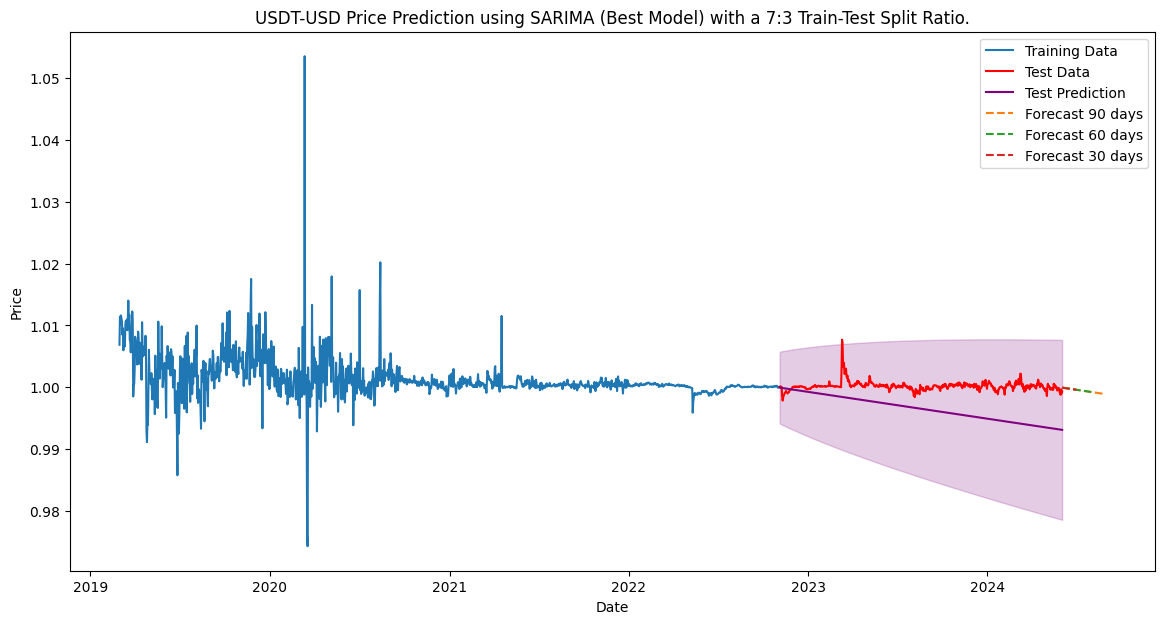

In [6]:
# Bước 4: Sử dụng mô hình tốt nhất để dự đoán trên tập test
test_pred = best_model.get_prediction(start=test_data.index[0], end=test_data.index[-1])
test_pred_mean = test_pred.predicted_mean
test_conf_int = test_pred.conf_int()

# Đảo ngược thứ tự vẽ từ dài nhất đến ngắn nhất
forecast_steps = [90, 60, 30]
forecasts = {}

for steps in forecast_steps:
    forecast_result = best_model.get_forecast(steps=steps)
    forecasts[steps] = forecast_result.predicted_mean

# Hiển thị kết quả
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='red')

# Dự đoán cho tập test
plt.plot(test_pred_mean, label='Test Prediction', color='purple')
plt.fill_between(test_conf_int.index, test_conf_int.iloc[:, 0], test_conf_int.iloc[:, 1], color='purple', alpha=0.2)

# Dự đoán cho 30, 60 và 90 ngày tiếp theo, vẽ từ dài nhất đến ngắn nhất
for steps in forecast_steps:
    plt.plot(pd.date_range(start=test_data.index[-1], periods=steps, freq='D'),
             forecasts[steps], label=f'Forecast {steps} days', linestyle='--')

plt.title('USDT-USD Price Prediction using SARIMA (Best Model) with a 7:3 Train-Test Split Ratio.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
# Tính các chỉ số
# MAPE: Tính thủ công do sklearn không có sẵn
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_data, test_pred_mean)
rmse = np.sqrt(mean_squared_error(test_data, test_pred_mean))
mae = mean_absolute_error(test_data, test_pred_mean)
mse = mean_squared_error(test_data, test_pred_mean)

# Hiển thị các chỉ số
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")

MAPE: 0.37%
RMSE: 0.00
MAE: 0.00
MSE: 0.00


Phân chia dữ liệu 6:4

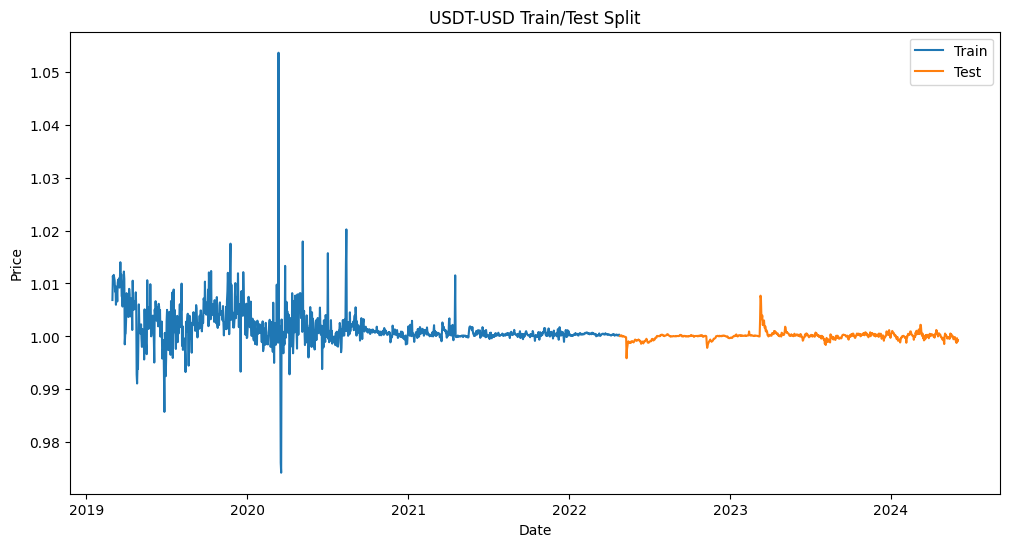

In [8]:
# Bước 2: Phân chia dữ liệu: 60% train, 40% test
train_size = int(len(data_diff) * 0.60)
train_data = data_diff.iloc[:train_size]
test_data = data_diff.iloc[train_size:]

# Vẽ biểu đồ để kiểm tra
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.title('USDT-USD Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Bước 3: Tìm kiếm mô hình SARIMA tốt nhất bằng Grid Search
p = d = q = range(0, 3)  # Định nghĩa phạm vi cho các tham số (p, d, q)
P = D = Q = range(0, 2)  # Định nghĩa phạm vi cho các tham số mùa vụ (P, D, Q)
s = [12]  # Kỳ mùa vụ (thường là 12 cho dữ liệu hàng tháng)

# Tạo tất cả các tổ hợp có thể có của các tham số ARIMA
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Thử tất cả các tổ hợp có thể có
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            sarima_fit = model.fit(disp=False)

            if sarima_fit.aic < best_aic:
                best_aic = sarima_fit.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = sarima_fit
        except:
            continue

print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq}12 with AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best SARIMA model: (1, 0, 2) x (0, 0, 0, 12)12 with AIC: -9994.278055564091


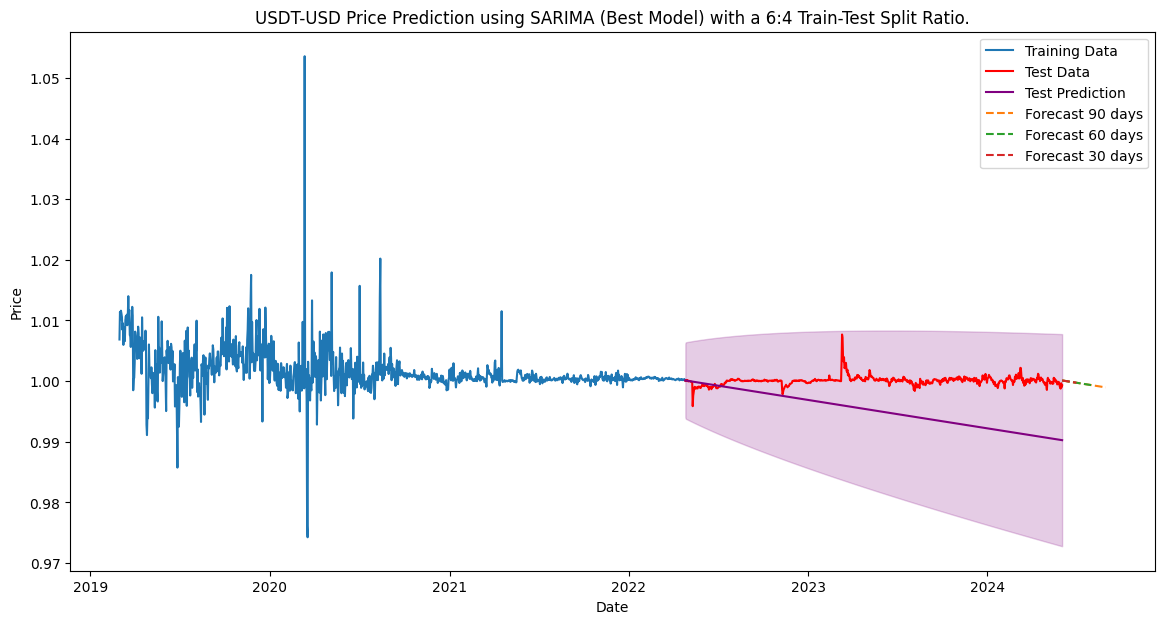

In [10]:
# Bước 4: Sử dụng mô hình tốt nhất để dự đoán trên tập test
test_pred = best_model.get_prediction(start=test_data.index[0], end=test_data.index[-1])
test_pred_mean = test_pred.predicted_mean
test_conf_int = test_pred.conf_int()

# Đảo ngược thứ tự vẽ từ dài nhất đến ngắn nhất
forecast_steps = [90, 60, 30]
forecasts = {}

for steps in forecast_steps:
    forecast_result = best_model.get_forecast(steps=steps)
    forecasts[steps] = forecast_result.predicted_mean

# Hiển thị kết quả
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='red')

# Dự đoán cho tập test
plt.plot(test_pred_mean, label='Test Prediction', color='purple')
plt.fill_between(test_conf_int.index, test_conf_int.iloc[:, 0], test_conf_int.iloc[:, 1], color='purple', alpha=0.2)

# Dự đoán cho 30, 60 và 90 ngày tiếp theo, vẽ từ dài nhất đến ngắn nhất
for steps in forecast_steps:
    plt.plot(pd.date_range(start=test_data.index[-1], periods=steps, freq='D'),
             forecasts[steps], label=f'Forecast {steps} days', linestyle='--')

plt.title('USDT-USD Price Prediction using SARIMA (Best Model) with a 6:4 Train-Test Split Ratio.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [11]:
# Tính các chỉ số
# MAPE: Tính thủ công do sklearn không có sẵn
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_data, test_pred_mean)
rmse = np.sqrt(mean_squared_error(test_data, test_pred_mean))
mae = mean_absolute_error(test_data, test_pred_mean)
mse = mean_squared_error(test_data, test_pred_mean)

# Hiển thị các chỉ số
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")

MAPE: 0.50%
RMSE: 0.01
MAE: 0.00
MSE: 0.00


**Chia tập dữ liệu 8:2**

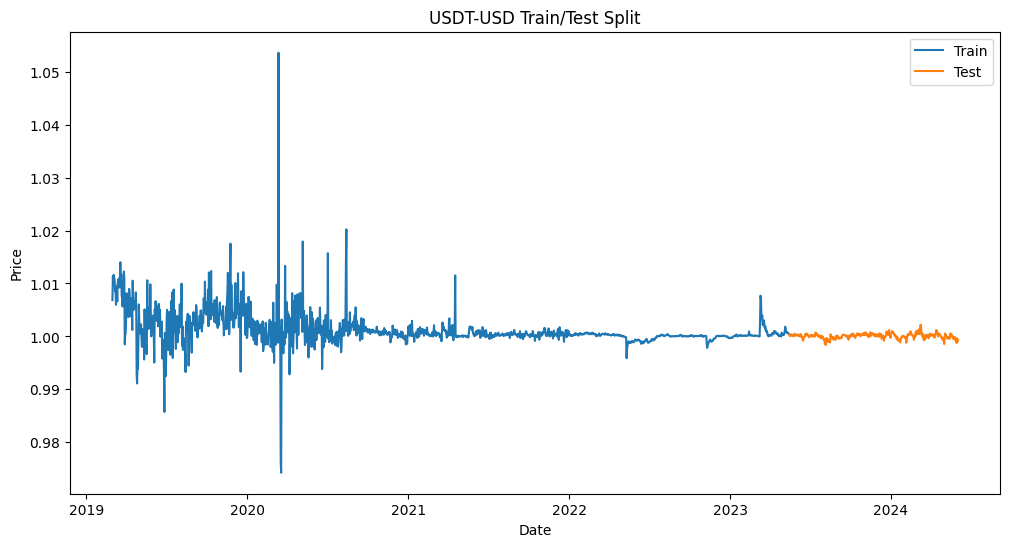

In [12]:
# Bước 2: Phân chia dữ liệu: 80% train, 20% test
train_size = int(len(data_diff) * 0.80)
train_data = data_diff.iloc[:train_size]
test_data = data_diff.iloc[train_size:]

# Vẽ biểu đồ để kiểm tra
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.title('USDT-USD Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
# Bước 3: Tìm kiếm mô hình SARIMA tốt nhất bằng Grid Search
p = d = q = range(0, 3)  # Định nghĩa phạm vi cho các tham số (p, d, q)
P = D = Q = range(0, 2)  # Định nghĩa phạm vi cho các tham số mùa vụ (P, D, Q)
s = [12]  # Kỳ mùa vụ (thường là 12 cho dữ liệu hàng tháng)

# Tạo tất cả các tổ hợp có thể có của các tham số ARIMA
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Thử tất cả các tổ hợp có thể có
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            sarima_fit = model.fit(disp=False)

            if sarima_fit.aic < best_aic:
                best_aic = sarima_fit.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = sarima_fit
        except:
            continue

print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq}12 with AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best SARIMA model: (1, 0, 2) x (0, 0, 0, 12)12 with AIC: -13759.392867502884


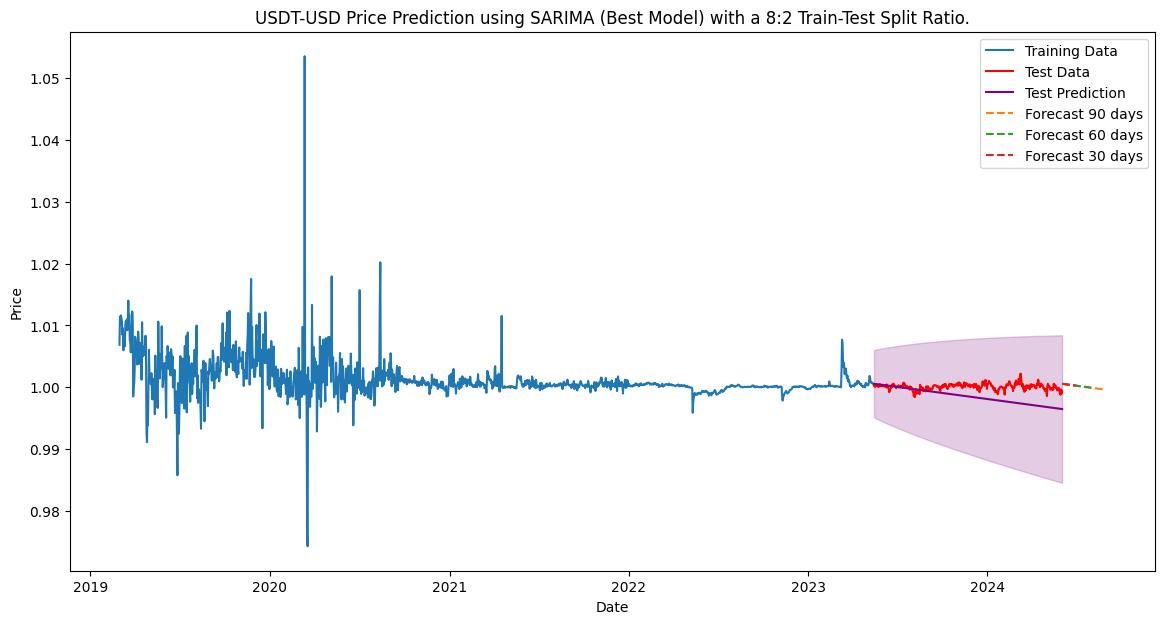

In [14]:
# Bước 4: Sử dụng mô hình tốt nhất để dự đoán trên tập test
test_pred = best_model.get_prediction(start=test_data.index[0], end=test_data.index[-1])
test_pred_mean = test_pred.predicted_mean
test_conf_int = test_pred.conf_int()

# Đảo ngược thứ tự vẽ từ dài nhất đến ngắn nhất
forecast_steps = [90, 60, 30]
forecasts = {}

for steps in forecast_steps:
    forecast_result = best_model.get_forecast(steps=steps)
    forecasts[steps] = forecast_result.predicted_mean

# Hiển thị kết quả
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='red')

# Dự đoán cho tập test
plt.plot(test_pred_mean, label='Test Prediction', color='purple')
plt.fill_between(test_conf_int.index, test_conf_int.iloc[:, 0], test_conf_int.iloc[:, 1], color='purple', alpha=0.2)

# Dự đoán cho 30, 60 và 90 ngày tiếp theo, vẽ từ dài nhất đến ngắn nhất
for steps in forecast_steps:
    plt.plot(pd.date_range(start=test_data.index[-1], periods=steps, freq='D'),
             forecasts[steps], label=f'Forecast {steps} days', linestyle='--')

plt.title('USDT-USD Price Prediction using SARIMA (Best Model) with a 8:2 Train-Test Split Ratio.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [15]:
# Tính các chỉ số
# MAPE: Tính thủ công do sklearn không có sẵn
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_data, test_pred_mean)
rmse = np.sqrt(mean_squared_error(test_data, test_pred_mean))
mae = mean_absolute_error(test_data, test_pred_mean)
mse = mean_squared_error(test_data, test_pred_mean)

# Hiển thị các chỉ số
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")

MAPE: 0.17%
RMSE: 0.00
MAE: 0.00
MSE: 0.00
